# Import Libraries

In [693]:
# Importing required libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import random


**LOAD DATASET**

In [694]:
DATASET_DIR = r'C:\Users\User\Downloads\archive\animals\animals'
CATEGORIES = os.listdir(DATASET_DIR)
IMG_SIZE = 32
NUM_IMAGES = 300


**Data Collection**



In [695]:
all_data = []
for category in CATEGORIES:
    path = os.path.join(DATASET_DIR, category)
    class_index = CATEGORIES.index(category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        all_data.append((img_path, class_index, img_name))  

random.shuffle(all_data)
selected_data = all_data[:NUM_IMAGES]


### **Preprocessing Images**



In [696]:
features = []
labels = []
display_data = []

for img_path, class_index, img_name in selected_data:
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        features.append(img.flatten() / 255.0)
        labels.append(class_index)
        display_data.append((img, class_index, img_name))
    except:
        continue

features = np.array(features)
labels = np.array(labels)

print(f"\nTotal  samples: {len(display_data)}") 



Total  samples: 300


**Image Visualization**



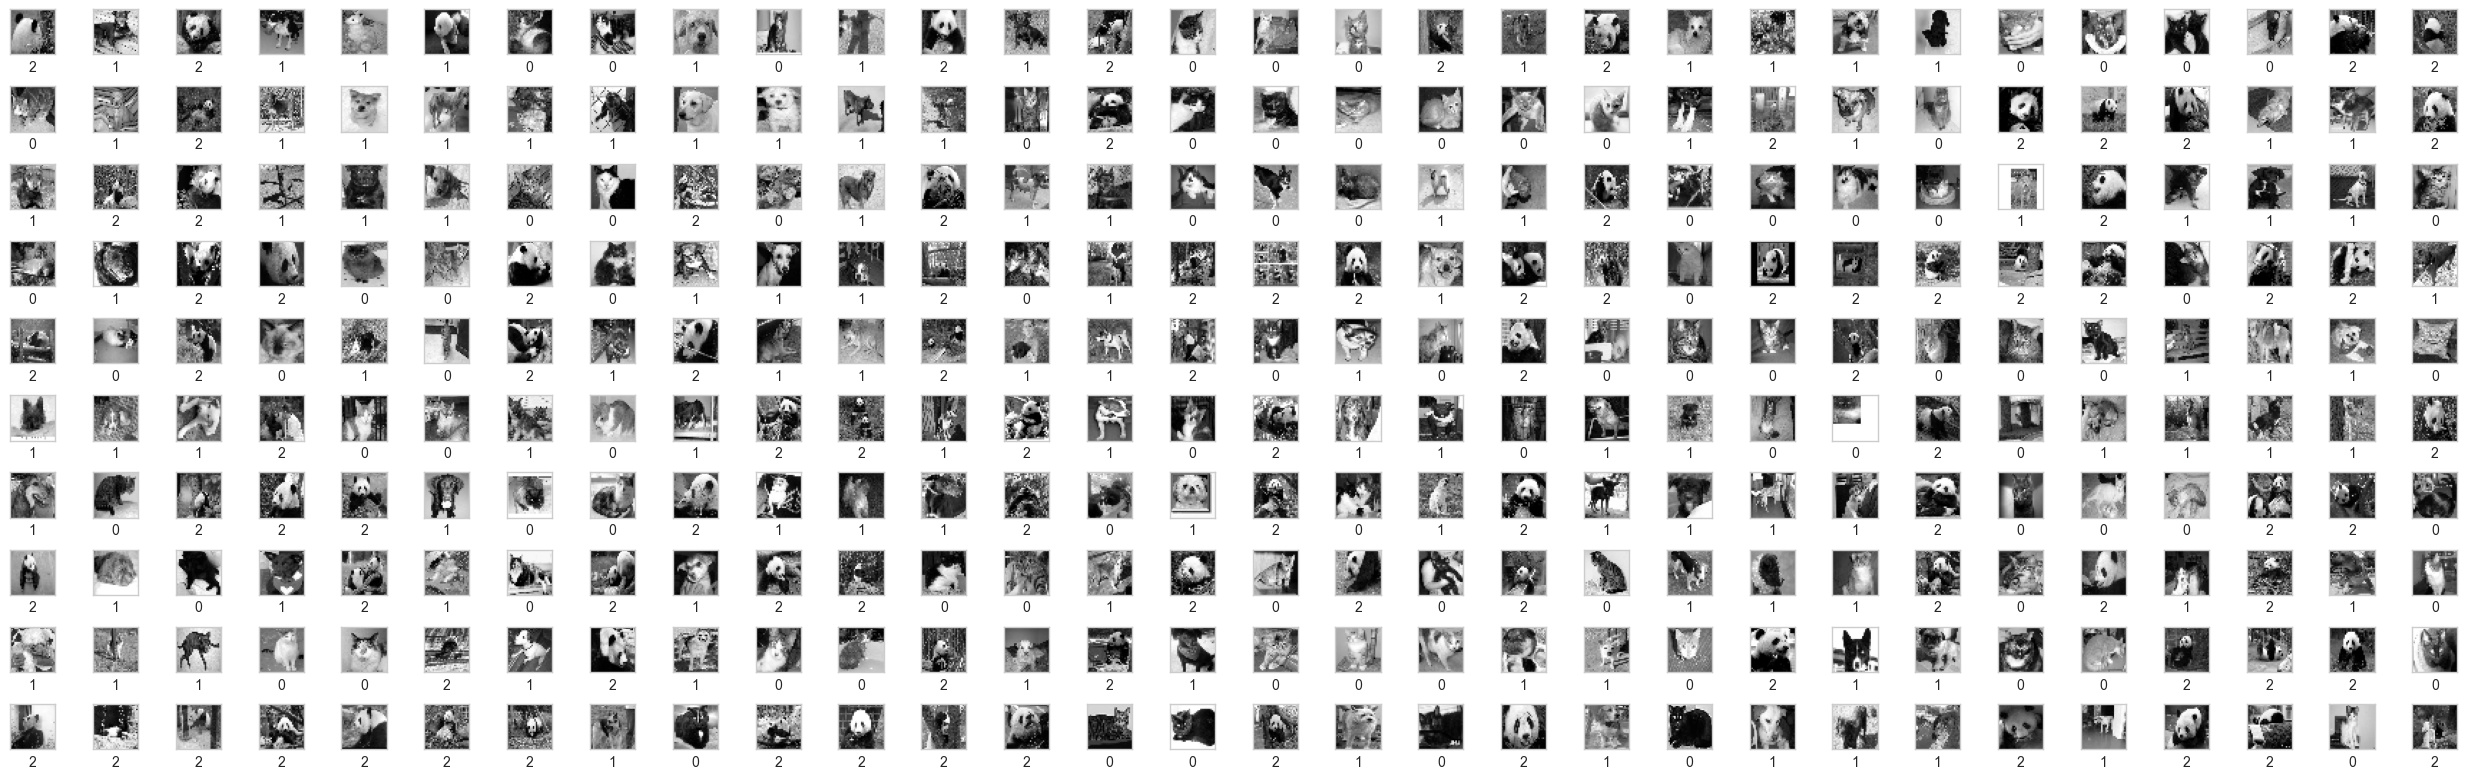

Total images processed: 300


In [697]:

plt.figure(figsize=(25, 25))
for i in range(len(display_data)):
    
    plt.subplot(30, 30, i + 1)
    plt.imshow(display_data[i][0],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(display_data[i][1])
    i+=1
   
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

print("Total images processed:", len(features))

** Distances **

In [698]:
def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

# Euclidean Distance (L2)
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))


**5-Fold Preparation**



In [ ]:

data = list(zip(features, labels))  


random.shuffle(data)


fold_size = len(data) // 5
folds = [data[i * fold_size : (i + 1) * fold_size] for i in range(5)]


remainder = len(data) % 5
for i in range(remainder):
    folds[i].append(data[5 * fold_size + i])


for i, fold in enumerate(folds):
    print(f"Fold {i+1} size:", len(fold))


Fold 1 size: 60
Fold 2 size: 60
Fold 3 size: 60
Fold 4 size: 60
Fold 5 size: 60


**KNN Prediction**



In [ ]:
def knn_predict(X_train, y_train, x_test, k=7, distance_type='l2'):
    distances = []
    for i in range(len(X_train)):
        if distance_type == 'l1':
            dist = manhattan_distance(X_train[i], x_test)
        else:
            dist = euclidean_distance(X_train[i], x_test)
        distances.append((dist, y_train[i]))
    
 
    distances.sort(key=lambda x: x[0])

  
    k_labels = [label for _, label in distances[:k]]

    
    most_common = Counter(k_labels).most_common(1)
    return most_common[0][0]


In [ ]:
def run_knn_cross_validation(folds, k_values, distance_type='l2'):
    fold_wise_accuracies = []

    for fold_index in range(5):
        
        validation_data = folds[fold_index]
        training_data = []
        for i in range(5):
            if i != fold_index:
                training_data.extend(folds[i])

        
        X_train = np.array([item[0] for item in training_data])
        y_train = np.array([item[1] for item in training_data])
        X_val = np.array([item[0] for item in validation_data])
        y_val = np.array([item[1] for item in validation_data])

        fold_accuracies = []

        for k in k_values:
            correct = 0
            for i in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[i], k=k, distance_type=distance_type)
                if pred == y_val[i]:
                    correct += 1
            accuracy = (correct / len(X_val)) * 100
            fold_accuracies.append(accuracy)

        fold_wise_accuracies.append(fold_accuracies)

    avg_accuracies = np.mean(fold_wise_accuracies, axis=0)
    return fold_wise_accuracies, avg_accuracies


Fold-wise Accuracies (L1 - Manhattan Distance):
Fold 1: [41.67 38.33 43.33 46.67 50.  ]
Fold 2: [50.   63.33 66.67 60.   66.67]
Fold 3: [48.33 46.67 51.67 48.33 50.  ]
Fold 4: [38.33 48.33 36.67 38.33 46.67]
Fold 5: [45.   53.33 51.67 53.33 48.33]

Fold-wise Accuracies (L2 - Euclidean Distance):
Fold 1: [33.33 45.   38.33 38.33 38.33]
Fold 2: [50.   58.33 65.   60.   61.67]
Fold 3: [46.67 45.   38.33 38.33 46.67]
Fold 4: [41.67 43.33 38.33 43.33 46.67]
Fold 5: [43.33 46.67 48.33 50.   50.  ]


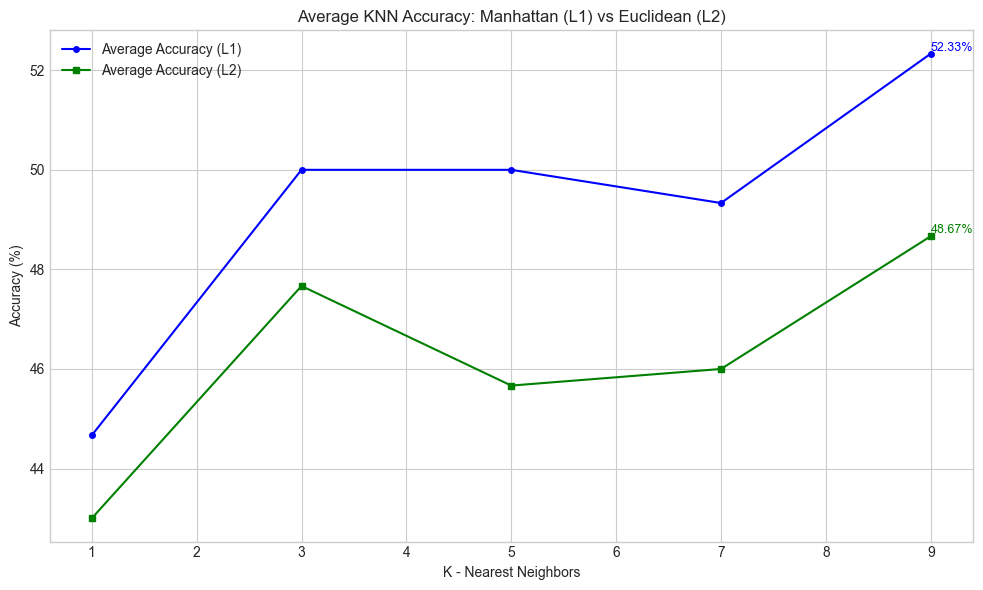

In [ ]:

K_values = [1, 3, 5, 7, 9]


fold_acc_l1, avg_acc_l1 = run_knn_cross_validation(folds, K_values, distance_type='l1')
fold_acc_l2, avg_acc_l2 = run_knn_cross_validation(folds, K_values, distance_type='l2')


print("Fold-wise Accuracies (L1 - Manhattan Distance):")
for i, acc in enumerate(fold_acc_l1):
    print(f"Fold {i+1}: {np.round(acc, 2)}")

print("\nFold-wise Accuracies (L2 - Euclidean Distance):")
for i, acc in enumerate(fold_acc_l2):
    print(f"Fold {i+1}: {np.round(acc, 2)}")


def plot_combined_avg_accuracy(K, avg_l1, avg_l2):
    plt.figure(figsize=(10, 6))

    
    plt.plot(K, avg_l1, 'o-', color='blue', label='Average Accuracy (L1)', markersize=4, linewidth=1.5)
    plt.text(K[-1], avg_l1[-1], f'{avg_l1[-1]:.2f}%', color='blue', fontsize=9, ha='left', va='bottom')

    
    plt.plot(K, avg_l2, 's-', color='green', label='Average Accuracy (L2)', markersize=4, linewidth=1.5)
    plt.text(K[-1], avg_l2[-1], f'{avg_l2[-1]:.2f}%', color='green', fontsize=9, ha='left', va='bottom')

    plt.xlabel("K - Nearest Neighbors")
    plt.ylabel("Accuracy (%)")
    plt.title("Average KNN Accuracy: Manhattan (L1) vs Euclidean (L2)")
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(1, 10,1))
    plt.tight_layout()
    plt.show()


plot_combined_avg_accuracy(K_values, avg_acc_l1, avg_acc_l2)



**Show average accuracy distance**

In [703]:
print("Average Accuracy for Manhattan (L1) Distance:")
for i in range(len(K_values)):
    print(f"K = {K_values[i]:2d} : {avg_acc_l1[i]:.2f}%")

print("\nAverage Accuracy for Euclidean (L2) Distance:")
for i in range(len(K_values)):
    print(f"K = {K_values[i]:2d} : {avg_acc_l2[i]:.2f}%")


Average Accuracy for Manhattan (L1) Distance:
K =  1 : 44.67%
K =  3 : 50.00%
K =  5 : 50.00%
K =  7 : 49.33%
K =  9 : 52.33%

Average Accuracy for Euclidean (L2) Distance:
K =  1 : 43.00%
K =  3 : 47.67%
K =  5 : 45.67%
K =  7 : 46.00%
K =  9 : 48.67%


Shuffle and Split Data

In [ ]:

for i in range(len(features)):
    data.append([features[i], labels[i]])

random.shuffle(data)

split = int(0.8 * len(data))
train = data[:split]
test = data[split:]

train_x = []
train_y = []
for item in train:
    train_x.append(item[0])
    train_y.append(item[1])

test_x = []
test_y = []
for item in test:
    test_x.append(item[0])
    test_y.append(item[1])

train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)


 Accuracy Function

In [705]:
def get_accuracy(train_x, train_y, test_x, test_y, k=3, dist_type='l2'):
    correct = 0
    for i in range(len(test_x)):
        pred = knn_predict(train_x, train_y, test_x[i], k=k, distance_type=dist_type)
        if pred == test_y[i]:
            correct += 1
    return (correct / len(test_y)) * 100


**Top-5 Predictions Display**



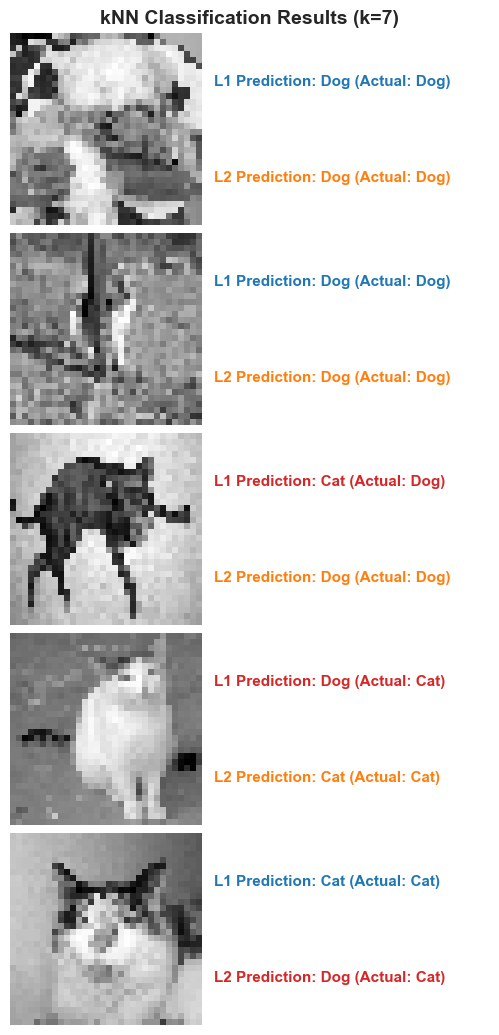

In [ ]:



split_index = int(0.8 * len(features))
X_train, X_test = features[:split_index], features[split_index:]
y_train, y_test = labels[:split_index], labels[split_index:]

class_names = ['Cat', 'Dog', 'Panda']

def show_top_5_predictions(X_train, y_train, X_test, y_test, class_names, k=7):
    
    plt.style.use('seaborn-v0_8-whitegrid')  
    fig, axes = plt.subplots(5, 1, figsize=(8, 10), constrained_layout=True)
    fig.patch.set_facecolor('white')  

    for i in range(5):
        
        img = X_test[i].reshape(32, 32, 3) if X_test[i].size == 32*32*3 else X_test[i].reshape(32, 32)

       
        pred_l1 = knn_predict(X_train, y_train, X_test[i], k=k, distance_type='l1')
        pred_l2 = knn_predict(X_train, y_train, X_test[i], k=k, distance_type='l2')

       
        l1_color = '#1f77b4' if pred_l1 == y_test[i] else '#d62728'  
        l2_color = '#ff7f0e' if pred_l2 == y_test[i] else '#d62728'  

       
        ax = axes[i] if len(axes) > 1 else axes
        if img.ndim == 2: 
            ax.imshow(img, cmap='gray', extent=(0, 32, 0, 32))
        else:  
            ax.imshow(img, extent=(0, 32, 0, 32))

        
        ax.text(34, 24, f"L1 Prediction: {class_names[pred_l1]} (Actual: {class_names[y_test[i]]})", 
                fontsize=11, color=l1_color, fontweight='bold', ha='left', va='center',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3'))
        ax.text(34, 8, f"L2 Prediction: {class_names[pred_l2]} (Actual: {class_names[y_test[i]]})", 
                fontsize=11, color=l2_color, fontweight='bold', ha='left', va='center',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3'))

        ax.set_xlim(0, 80)  
        ax.set_ylim(0, 32)
        ax.axis('off') 

  
    fig.suptitle('kNN Classification Results (k=7)', fontsize=14, fontweight='bold', y=1.02)
    plt.show()


show_top_5_predictions(X_train, y_train, X_test, y_test, class_names, k=7)



Based on the results, we can compare the performance of Manhattan (L1) and Euclidean (L2) distances:

L1 - Avarage Accuracy: around  50%

L2 - Avarage Accuracy: around  45%



